In [136]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('ignore')
import optuna
import time
import xgboost as xgb
from boruta import BorutaPy
from sklearn.model_selection import train_test_split
import catboost as cb 
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1. Data preprocessing

In [99]:
#Load data set
try:
    df = pd.read_csv('response_data.csv')
    print(df.sample(5))
except:
    print('Wrong file name!')

     bedrooms  bathrooms  squareFootage   propertyType  yearBuilt  price  \
89        1.0        1.0          700.0      Apartment     1926.0   3900   
293       2.0        1.0            NaN      Apartment     1905.0   3495   
23        NaN        1.0          250.0      Apartment        NaN   2900   
443       2.0        1.0            NaN      Apartment        NaN   3095   
409       3.0        2.0            NaN  Single Family     1899.0  12000   

     daysOnMarket               createdDate  zipCode  
89             53  2019-11-07T14:08:07.561Z    10019  
293            55  2019-05-09T15:33:13.959Z    10027  
23              3  2019-05-08T12:05:59.703Z    10016  
443           477  2019-09-17T06:14:07.756Z    10075  
409            28  2019-09-19T15:48:30.394Z    10014  


In [100]:
#Checking what problem  has dataset

def problem(df):

    print(df.info())
    print('#################################################')
    print(f'The percentily of missing values in data set is {round((df.isnull().sum().sum())/(len(df) * len(df.columns)) *100,1)} %')
    print('#################################################')
    print(f'The number of duplicates is {df.duplicated().sum()}')


In [101]:
#Calling previous function
problem(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       444 non-null    float64
 1   bathrooms      498 non-null    float64
 2   squareFootage  282 non-null    float64
 3   propertyType   500 non-null    object 
 4   yearBuilt      242 non-null    float64
 5   price          500 non-null    int64  
 6   daysOnMarket   500 non-null    int64  
 7   createdDate    500 non-null    object 
 8   zipCode        500 non-null    int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 35.3+ KB
None
#################################################
The percentily of missing values in data set is 11.9 %
#################################################
The number of duplicates is 0


> Before I can start working with my features like changing the type of them and providing some statistics and exploration analysis, I need to solve problems with missing values. So let's begin

In [102]:
#Checking in what feature and what number of missing values I have
df.isnull().sum()

bedrooms          56
bathrooms          2
squareFootage    218
propertyType       0
yearBuilt        258
price              0
daysOnMarket       0
createdDate        0
zipCode            0
dtype: int64

In [103]:
#First I will start working with "Bedrooms" feature.
#How many bedrooms more popular in the rent property
df['bedrooms'].value_counts()

1.0    183
2.0    157
3.0     76
4.0     20
5.0      4
0.0      2
6.0      2
Name: bedrooms, dtype: int64

In [104]:
#So I see that most of our flats belong to a one-bedroom type so what I propose is just replace all Nan-values by 1
df['bedrooms'] = df['bedrooms'].fillna(1.0)
df.bedrooms.value_counts()

1.0    239
2.0    157
3.0     76
4.0     20
5.0      4
0.0      2
6.0      2
Name: bedrooms, dtype: int64

In [105]:
#Bathrooms feature
print(df['bathrooms'].value_counts())
df.bathrooms = df.bathrooms.fillna(1.0)
print('######################')
print(df.bathrooms.value_counts())

1.0    357
2.0     84
1.5     14
3.0     14
2.5     13
3.5      9
4.5      3
6.0      1
6.5      1
5.5      1
4.0      1
Name: bathrooms, dtype: int64
######################
1.0    359
2.0     84
1.5     14
3.0     14
2.5     13
3.5      9
4.5      3
6.0      1
6.5      1
5.5      1
4.0      1
Name: bathrooms, dtype: int64


In [106]:
#squareFootage feature
df.squareFootage.describe()

count      282.000000
mean      1719.709220
std       7092.270971
min          0.000000
25%        612.750000
50%        788.500000
75%       1159.000000
max      94516.000000
Name: squareFootage, dtype: float64

In [107]:
#From the previous line of code I see that I have a bit of outliers and problem values, like ("0") because I don't think a property can have "0" square-footage
#So I propose to change all problematic values by "median"
mediana = df.squareFootage.median()
df.squareFootage = df.squareFootage.fillna(mediana)
df.squareFootage = df.squareFootage.replace(0,mediana)
df.squareFootage.describe()

count      500.0000
mean      1316.8560
std       5341.6538
min         10.0000
25%        750.0000
50%        788.5000
75%        831.0000
max      94516.0000
Name: squareFootage, dtype: float64

In [108]:
#And last features yearBuilt
df.yearBuilt.describe()

count     242.000000
mean     1951.214876
std        47.675025
min      1836.000000
25%      1910.000000
50%      1931.000000
75%      2005.000000
max      2019.000000
Name: yearBuilt, dtype: float64

> From my last function, I see that most of the property was built many years ago, and in addition to this sometimes people really don't know when the building was built, and if I just fill all missing values by oldest or newest year it may provide a wrong impact of price prediction. So in this step, I just simply fill all missing values by "0" will means the person doesn't know when the building or flat, etc. was built!

In [109]:
df.yearBuilt = df.yearBuilt.fillna(0)

In [110]:
#Looking аfter all that  I have done If my data set still has missing values
df.isnull().sum()

bedrooms         0
bathrooms        0
squareFootage    0
propertyType     0
yearBuilt        0
price            0
daysOnMarket     0
createdDate      0
zipCode          0
dtype: int64

In [111]:
#Creating an additional function that will change the type of feature to the necessary one
def change_type(df,col,type):
    df[col] = df[col].astype(type)
    return df[col]


In [112]:
#Assign all necessary features that must be transformed to a given type
col = ['bedrooms','bathrooms','squareFootage','yearBuilt','price','daysOnMarket','zipCode']
type = 'int16'

df[col] = change_type(df,col,type)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   bedrooms       500 non-null    int16 
 1   bathrooms      500 non-null    int16 
 2   squareFootage  500 non-null    int16 
 3   propertyType   500 non-null    object
 4   yearBuilt      500 non-null    int16 
 5   price          500 non-null    int16 
 6   daysOnMarket   500 non-null    int16 
 7   createdDate    500 non-null    object
 8   zipCode        500 non-null    int16 
dtypes: int16(7), object(2)
memory usage: 14.8+ KB
None


In [113]:
#Converting date feature to datetime format
df['createdDate'] = pd.to_datetime(df['createdDate'])
#Changing type of propertyType column to string
df.propertyType = df.propertyType.astype('string')
#Making all name of the features to lower case register
df.columns = df.columns.str.lower()

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   bedrooms       500 non-null    int16              
 1   bathrooms      500 non-null    int16              
 2   squarefootage  500 non-null    int16              
 3   propertytype   500 non-null    string             
 4   yearbuilt      500 non-null    int16              
 5   price          500 non-null    int16              
 6   daysonmarket   500 non-null    int16              
 7   createddate    500 non-null    datetime64[ns, UTC]
 8   zipcode        500 non-null    int16              
dtypes: datetime64[ns, UTC](1), int16(7), string(1)
memory usage: 14.8 KB


In [115]:
#Check what I have in my price feature
print(df.price.describe())
print('##########################')
print(df.squarefootage.describe())

count      500.000000
mean      5171.326000
std       4800.601445
min     -26536.000000
25%       3300.000000
50%       4495.000000
75%       5995.000000
max      30000.000000
Name: price, dtype: float64
##########################
count      500.000000
mean       923.420000
std       1882.188663
min     -26973.000000
25%        750.000000
50%        788.000000
75%        826.000000
max      28980.000000
Name: squarefootage, dtype: float64


- I think I have some problem with my price feature because in my mind I don't think ppl will rent out their property at a negative price, so let's check how many values we have with prices less than 0. And with Square footage too somethink wrong because we agree that can be footage with a negative number

In [116]:
#Number of broken prices
print(f"The number of the property with wrong price is {len(df.query('price < 0'))}")
print('#########################################################')
print(f"The number of the property with unreasonable footage is  {len(df.query('squarefootage < 0'))}")
      

The number of the property with wrong price is 6
#########################################################
The number of the property with unreasonable footage is  2


In [117]:
#Only 6 so I propose just drop them and move on
df = df.query('price > 0 and squarefootage > 0')
print(df.price.describe())
print('##################')
print(df.squarefootage.describe())

count      492.000000
mean      5487.782520
std       3833.086045
min        464.000000
25%       3349.500000
50%       4495.000000
75%       5996.250000
max      30000.000000
Name: price, dtype: float64
##################
count      492.000000
mean       949.684959
std       1371.025131
min         10.000000
25%        750.000000
50%        788.000000
75%        800.000000
max      28980.000000
Name: squarefootage, dtype: float64


# Part 2. Exploration Data Analysis 

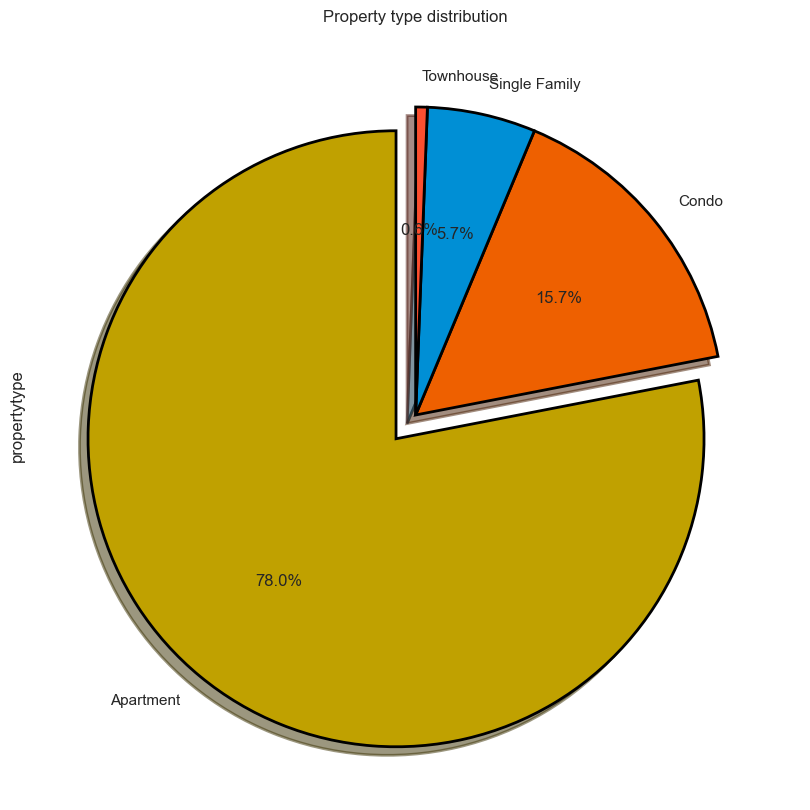

In [119]:
#Creating a pie chart to show what kind of bedrooms distribution I have in my dataset
colors = ['#c0a100','#ee6000','#008fd5','#fc4f30']
explode = [0.1,0,0,0]
df.propertytype.value_counts().plot.pie(explode=explode, shadow=True, colors=colors,startangle = 90,
                                    wedgeprops = {"edgecolor" : "black",'linewidth':2,
                                                  'antialiased':True}, autopct ='%1.1f%%',
                                                  figsize=(10,10),title="Property type distribution");

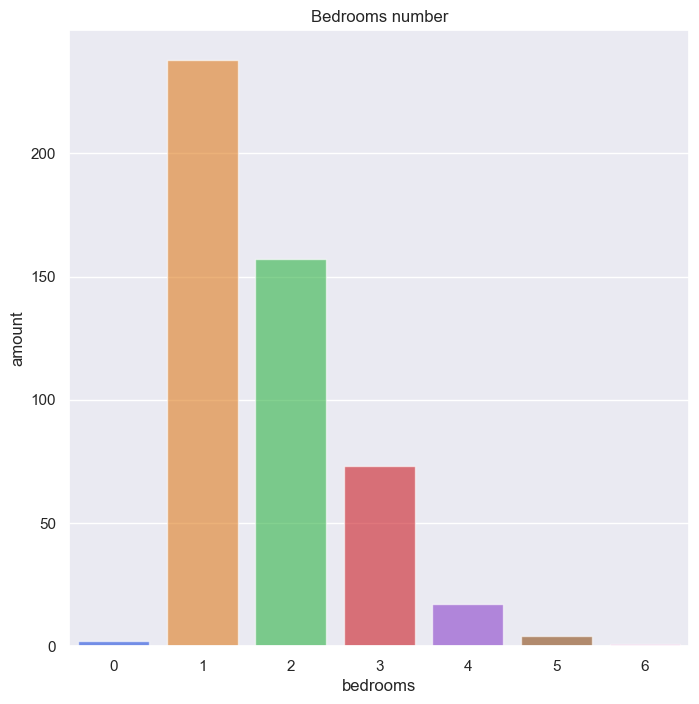

In [120]:
#Let's show with help of visualization what kind of bedrooms distribution in data set
bed_dis = df.bedrooms.value_counts().reset_index().rename(columns={'index':"bedrooms",
                                                                   'bedrooms':'amount'})
sns.set(rc={"figure.figsize":(8,8)})
sns.barplot(data= bed_dis, x='bedrooms', y='amount',palette='bright',alpha=0.6).set(title='Bedrooms number');

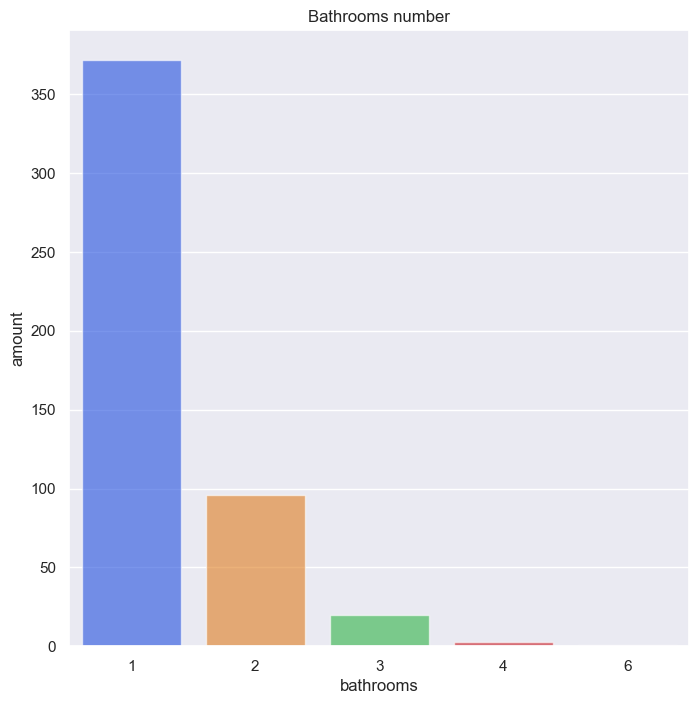

In [121]:
#Show what kind of distribution by number of bathrooms
bed_dis = df.bathrooms.value_counts().reset_index().rename(columns={'index':"bathrooms",
                                                                   'bathrooms':'amount'})
sns.set(rc={"figure.figsize":(8,8)})
sns.barplot(data= bed_dis, x='bathrooms', y='amount',palette='bright',alpha=0.6).set(title='Bathrooms number');

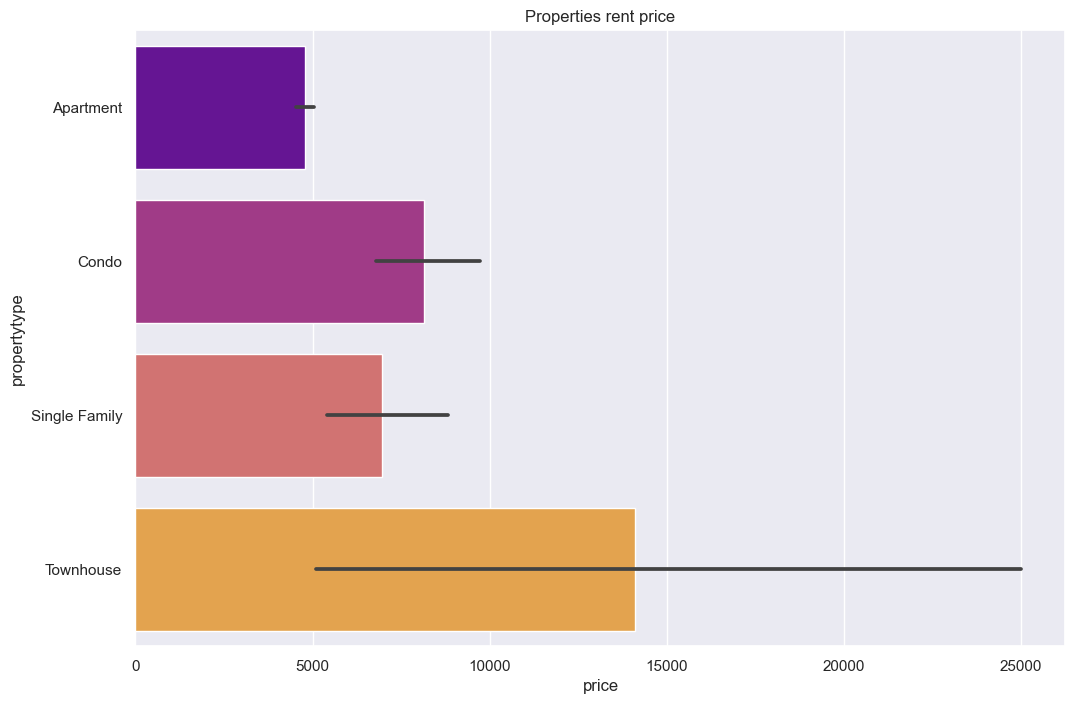

In [122]:
#Price distribution depends on the type of rent out properties
#create fig object
plt.figure(figsize=(12,8))
#horizontal bar chart showing price depending on the type of rent out properties
sns.barplot(x='price',y='propertytype',data=df,palette='plasma').set(title='Properties rent out price');

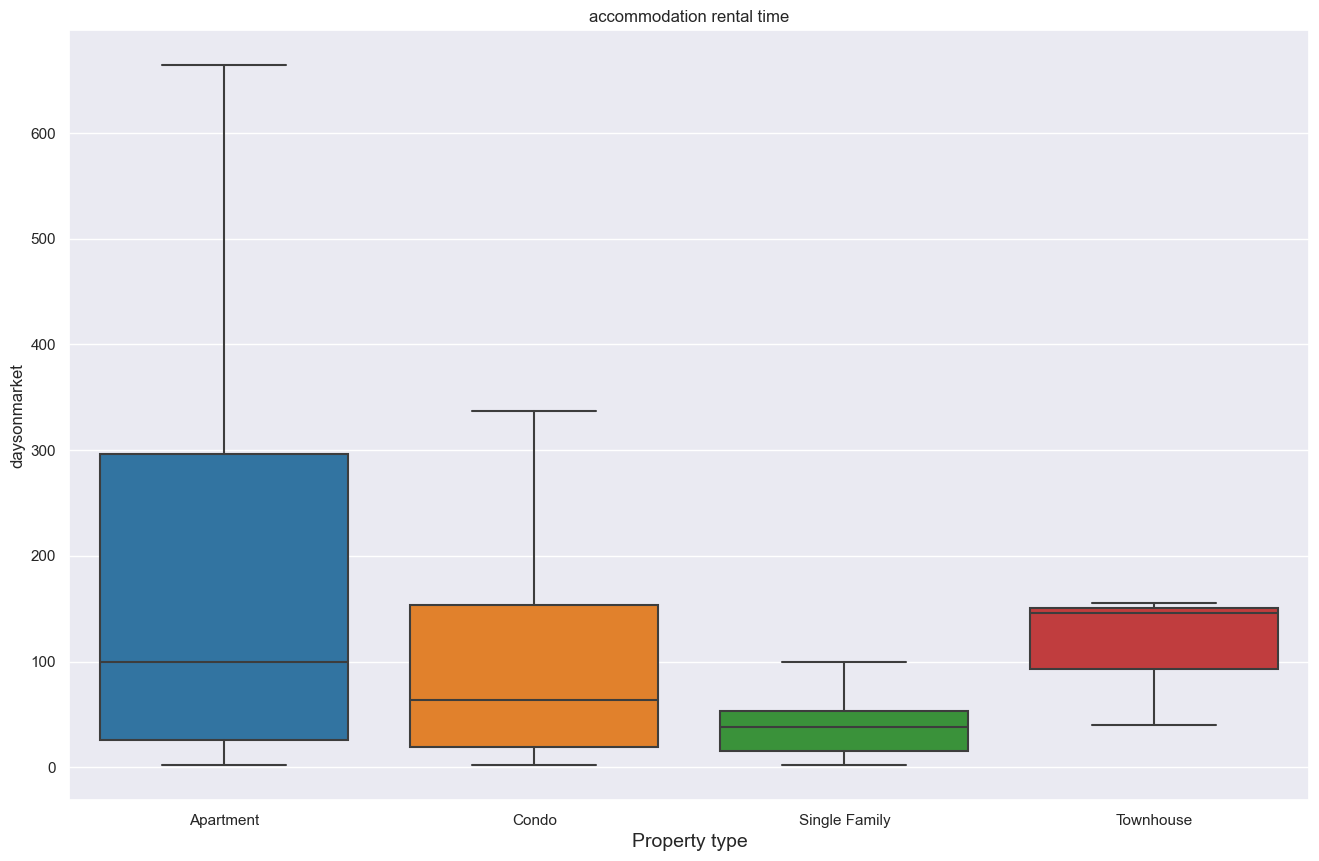

In [123]:
#Showing what most hardest type of property to be rented
fig, axis= plt.subplots(1,1, figsize=(16,10))
sns.boxplot(data=df, x='propertytype', y='daysonmarket',palette='tab10',showfliers=False, ax=axis).set(title='Accommodation rental out time')
axis.set_xlabel('Property type',fontsize=14);

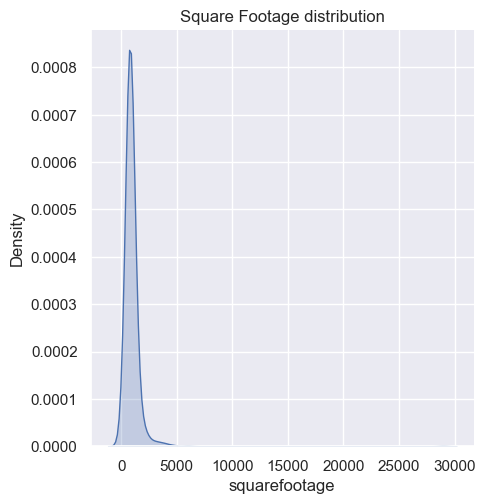

In [159]:
#Plotting Square footage distribution that will provide a clear picture of what range of footage belongs to most rental properties
sns.displot(df,x='squarefootage',kind='kde',fill=True).set(title='Square Footage distribution');

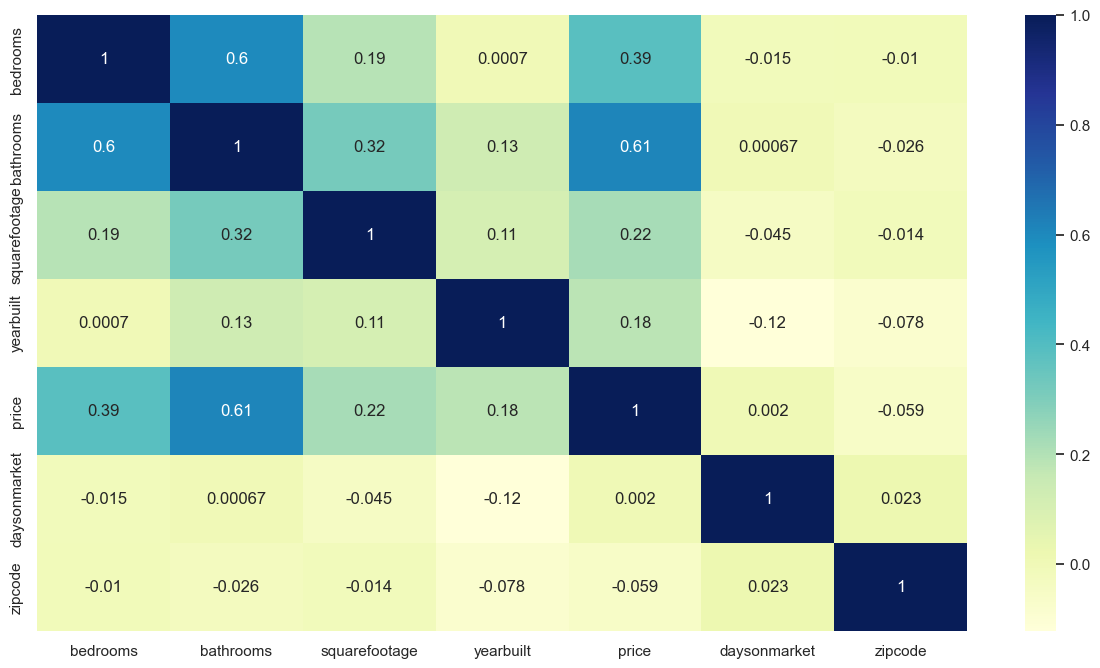

In [161]:
#Correlation in data set
#Plotting heatmap of correlation
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(),annot=True, cmap='YlGnBu');

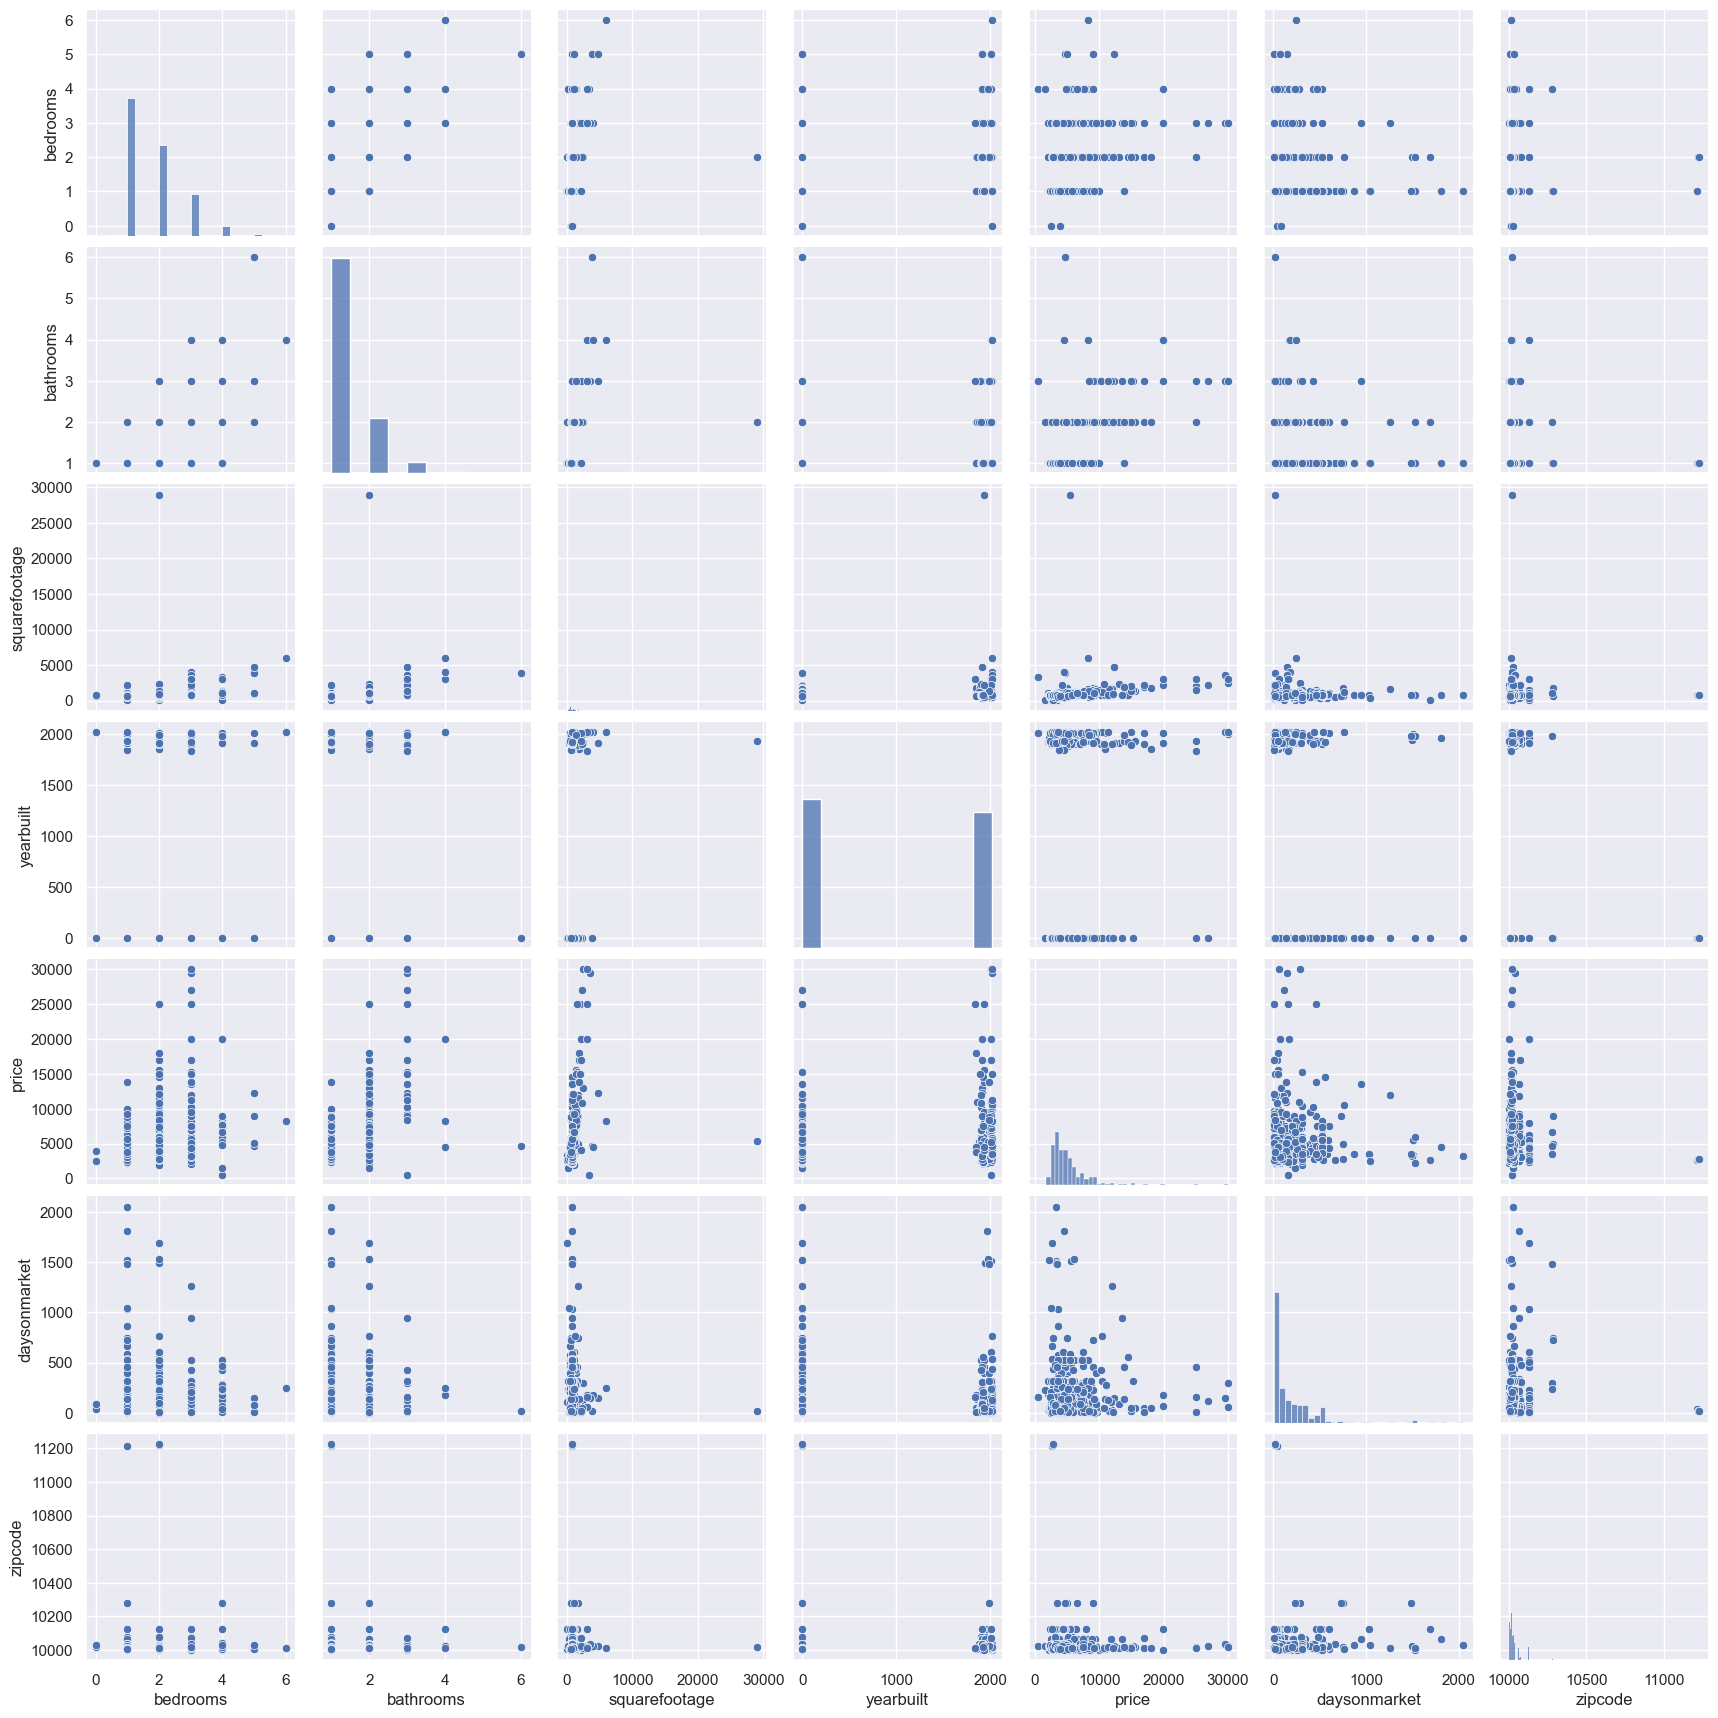

In [162]:
sns.pairplot(df,palette='Set1');

> Conclusion: In this part of the project I provided the next analysis:
- The most common type  of rental property in the data set is an Apartment
- Most of the properties have one bedroom and one bathroom
- The expensive property is a TownHouse
- But the hardes  types of renting out property is a TownHouse
- And most of the property lies in the range of Square footage from 0 to 2500
- Lastly I show what kind of impact each features has to the target variable(**price**)

## Part 3. Working with model

### Feature selection

In [127]:
#Dividing the data set into features and target subset
X = df.drop(['price','createddate'],axis=1)
y = df['price']


> When you use tree-based models such as XGboos, LighGBM, RandoForest, Catboost, etc., you don't need to provide normalization because in these types of algorithms only the ordering matters, the magnitude/scale does not. But if you want to provide feature selection you need to normalize data before you start using any of the feature selection methods.


In [142]:
#Using MinMaxscaler for normalization scale of each feature
#First encoding categorical feature
label_encoder = LabelEncoder()
X['propertytype'] = label_encoder.fit_transform(X['propertytype'])
scaler = MinMaxScaler()
features =  pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
features

,bedrooms,bathrooms,squarefootage,propertytype,yearbuilt,daysonmarket,zipcode
0,0.333333,0.0,0.024163,0.000000,0.000000,0.026354,0.001633
1,0.166667,0.0,0.023473,0.333333,0.984646,0.025866,0.001633
2,0.166667,0.0,0.016914,0.000000,0.000000,0.004880,0.010612
3,0.166667,0.0,0.026855,0.000000,0.995047,0.083455,0.019592
4,0.166667,0.0,0.025682,0.000000,0.000000,0.002440,0.002449
...,...,...,...,...,...,...,...
487,0.166667,0.0,0.026855,0.000000,0.000000,0.152269,0.007347
488,0.333333,0.2,0.030721,0.000000,0.000000,0.001464,0.007347
489,0.666667,0.2,0.036762,0.000000,0.000000,0.115666,0.227755
490,0.166667,0.0,0.016914,0.000000,0.000000,0.152269,0.003265


In [133]:
np.int = np.int_
np.float = np.float_
np.bool = np.bool_

In [134]:
#Selection of features using the automatic borut method and the use of the XGB algorithm
model = xgb.XGBRegressor()#Assign model
feat_selector = BorutaPy(model,n_estimators='auto',verbose=True,random_state=1234)#Creating a features selection model
feat_selector.fit(features.values,y.values.ravel())

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

BorutaPy(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=None, gpu_id=None,
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None,
                                learning_rate=None, max_bin=None,
                                max_cat_threshold=None, max_cat_to_onehot=None,
                                max_delta_step=None, max_depth=None,
                                max_leaves=None, min_child_weight=None,
                                missing=nan, monotone_constraints=None,
                                n_estimators=24, n_jobs=None,
                                num_parallel_tree=None, predictor=None,
                                random_state=2081126692, ...),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x2F5B9BE40,
         verbose=True)

In [135]:
#Showing the rank of each feature
rank = pd.Series(feat_selector .ranking_)
col = pd.Series(features.columns)
pd.concat([col,rank],axis=1)

,0,1
0,bedrooms,2
1,bathrooms,1
2,squarefootage,1
3,propertytype,5
4,yearbuilt,5
5,daysonmarket,5
6,zipcode,3


> From the Boruta we can see that only 2 features will be enough to make a good prediction, I propose first using all features to make a prediction and after using only 2 that were selected by Boruta, and will check if our accuracy will be the same or not

In [143]:

#Splitting into train and validation sets
X_train,X_val ,y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=423)
print(X_train.shape)
print(X_val.shape)

(393, 7)
(99, 7)


In [148]:
#Define the objective function, which Optuna aims to optimize
def objective(trial):
    params = {
        'iterations':1000,#Number of tress or steps the algorithms takes to create a more accurate model that learns from the data.
        #100-200 times for real-time data and 1000-2000 for batch applications.
        'learning_rate': trial.suggest_float('learning_rate',1e-4,0.1,log=True),#it scales the contribution of each decision tree to manage the overall balance
        #and accuracy of the model, but smallaer LR - can lead to underfitting, a larger learning rate - can lead to overfitting
        'depth': trial.suggest_int("depth",1,10),#The higher depth can capture more intricate patterns in data,
        #but the deeper the tree the more time it takes to train, and higher ther risk of overfitting 
        'subsample': trial.suggest_float("subsample",0.05,1.0),#Used to randomly choose a fraction of the dataset, hepls reduce overfitting
        'colsample_bylevel' :trial.suggest_float("colsample_bylevel", 0.05,1.0),#the same as subsample but splitting the features not the rows
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 1,100)#specifies the minimum number of samples required to create a leaf

    }

    model = cb.CatBoostRegressor(**params,silent=True)
    model.fit(X_train,y_train)
    predictions = model.predict(X_val)
    rmse = mean_squared_error(y_val,predictions,squared=False)
    return rmse



In [149]:
#working with optuna method
study = optuna.create_study(direction='minimize')#The direction parameter specifies whether we want to minimize or maximize the objective function
#since the lower RMSE indicates a better model, our aim is to minimize it
study.optimize(objective,n_trials=30)#n_trials define the number of times the model will be trained with different hyperparameters values

[I 2023-11-03 17:48:43,586] A new study created in memory with name: no-name-a5a009bc-3763-4442-8757-ed91106928fb
[I 2023-11-03 17:48:43,957] Trial 0 finished with value: 3293.897522374541 and parameters: {'learning_rate': 0.0025489250459884596, 'depth': 7, 'subsample': 0.14321989852491612, 'colsample_bylevel': 0.7147460567712812, 'min_data_in_leaf': 87}. Best is trial 0 with value: 3293.897522374541.
[I 2023-11-03 17:48:44,091] Trial 1 finished with value: 3719.2559329896567 and parameters: {'learning_rate': 0.000608044786101318, 'depth': 4, 'subsample': 0.8634071238403282, 'colsample_bylevel': 0.4207349798057126, 'min_data_in_leaf': 77}. Best is trial 0 with value: 3293.897522374541.
[I 2023-11-03 17:48:44,270] Trial 2 finished with value: 3231.3439423072646 and parameters: {'learning_rate': 0.034564531171964535, 'depth': 8, 'subsample': 0.4498485729682863, 'colsample_bylevel': 0.24984609345550512, 'min_data_in_leaf': 25}. Best is trial 2 with value: 3231.3439423072646.
[I 2023-11-03

In [150]:
#Fetch the best hyperparameters
print(f"Best hyperparameters: {study.best_params}")

Best hyperparameters: {'learning_rate': 0.05227476354596801, 'depth': 1, 'subsample': 0.7767469548302696, 'colsample_bylevel': 0.2533632496515409, 'min_data_in_leaf': 57}


> I have a big number of ***RMSE*** because a small data set was provided to the model. I can use different types of sampling or bootstraping but for this project, I just wanna show how you can combine ***Data Engineer and ML engineer***.

In [155]:
#Checking how model will work with only two features that were selected by boruta
X_upd = X_train[['bathrooms','squarefootage']]
X_val_upd = X_val[['bathrooms','squarefootage']]

In [156]:
#Define the objective function, which Optuna aims to optimize
def objective(trial):
    params = {
        'iterations':1000,#Number of tress or steps the algorithms takes to create a more accurate model that learns from the data.
        #100-200 times for real-time data and 1000-2000 for batch applications.
        'learning_rate': trial.suggest_float('learning_rate',1e-4,0.1,log=True),#it scales the contribution of each decision tree to manage the overall balance
        #and accuracy of the model, but smallaer LR - can lead to underfitting, a larger learning rate - can lead to overfitting
        'depth': trial.suggest_int("depth",1,10),#The higher depth can capture more intricate patterns in data,
        #but the deeper the tree the more time it takes to train, and higher ther risk of overfitting 
        'subsample': trial.suggest_float("subsample",0.05,1.0),#Used to randomly choose a fraction of the dataset, hepls reduce overfitting
        'colsample_bylevel' :trial.suggest_float("colsample_bylevel", 0.05,1.0),#the same as subsample but splitting the features not the rows
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 1,100)#specifies the minimum number of samples required to create a leaf

    }

    model = cb.CatBoostRegressor(**params,silent=True)
    model.fit(X_upd,y_train)
    predictions = model.predict(X_val_upd)
    rmse = mean_squared_error(y_val,predictions,squared=False)
    return rmse


In [157]:
#working with optuna method
study = optuna.create_study(direction='minimize')#The direction parameter specifies whether we want to minimize or maximize the objective function
#since the lower RMSE indicates a better model, our aim is to minimize it
study.optimize(objective,n_trials=30)#n_trials define the number of times the model will be trained with different hyperparameters values

[I 2023-11-03 18:42:46,709] A new study created in memory with name: no-name-9af5b6f4-2716-4024-bf42-a54862a0221d
[I 2023-11-03 18:42:46,774] Trial 0 finished with value: 3556.1883267079775 and parameters: {'learning_rate': 0.06865779967433407, 'depth': 1, 'subsample': 0.6489107827299576, 'colsample_bylevel': 0.8679034806955344, 'min_data_in_leaf': 21}. Best is trial 0 with value: 3556.1883267079775.
[I 2023-11-03 18:42:46,824] Trial 1 finished with value: 4321.613563597277 and parameters: {'learning_rate': 0.00011410014868070419, 'depth': 1, 'subsample': 0.879025510714783, 'colsample_bylevel': 0.5995064614246558, 'min_data_in_leaf': 31}. Best is trial 0 with value: 3556.1883267079775.
[I 2023-11-03 18:42:46,872] Trial 2 finished with value: 4220.400762386119 and parameters: {'learning_rate': 0.0002460540351094974, 'depth': 1, 'subsample': 0.6946853081712538, 'colsample_bylevel': 0.4572146966699985, 'min_data_in_leaf': 62}. Best is trial 0 with value: 3556.1883267079775.
[I 2023-11-03 

> From the previous code I can see that, smallest number of features provided better ***RMSE*** value

# Overall Conclusion:

- In this part of my project I used a data set that I had after the ETL process in the Data Engineer part. This data set consists **9** features, **500** rows, and information about rental property and their price. The goal(target) of this project was to create a model that would predict **price** of the renting property.
The first step was to load and process data. In this step I found that I had around **12%** of missing values in the data set, so after several transformations and refilling, I solved that problem and went further. Then I looked inside each type of feature and retyped some of them, which gave me a free space for memory, and provided a bit of easier life for the next operations.
- After I came to ***EDA***. Here I showed what type of property belongs to most of the renting properties, and found that is ***Apartment*** most common type of renting properties.
- In the next, I checked what common number of bathrooms and bedrooms have renting properties and found that in my case most of the properties have ***one bedroom *** and ***one bathroom ***
- Then I found that the most expensive type of property is ***TownHouse***, but at the same time this is the longest type of to be renting out property
- Also I checked that most of the properties lie in the range  ***square-footage***  from ***100 to 2500***
- At last I showed from what features most depends **target(Price)** variable by plotting **heatmap and scatterplot** and also by using method **Boruta** and in result the **Price** variable depends most from number of **Bathrooms and Bedrooms**
- After **EDA** I came to **Model creating and evaluation** part of the project.
- Here I worked with **Catboost** model and **Boruta** feature selection method, for the hyperparameters tunning method I used automating **Optuna**, but due to my small number of data, I had a bad RMSE number. But this is a ***Test*** project just showing how easily u can apply together ***Data Engineer and ML engineer** techniques.

## Thank you for your attention!